In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# functions, global variables, and default values (described below) from the lignin-kmc Package 
from ligninkmc.create_lignin import (calc_rates, create_initial_monomers, create_initial_events, 
                                     create_initial_state, adj_analysis_to_stdout, DEF_ADD_RATE)
from ligninkmc.kmc_functions import (run_kmc, generate_mol, analyze_adj_matrix)
from ligninkmc.kmc_common import (DEF_E_BARRIER_KCAL_MOL, GROW, OX, BO4, B5, BB, B1, C5O4, AO4, C5C5, G, S, C,
                                  MONOMER, MONO_LIST, ADJ_MATRIX, BONDS, CHAIN_LEN, RCF_YIELDS, Event, Monomer)

# General Math and LinAlg
import numpy as np
from scipy import optimize

# Chemical Drawing
from rdkit.Chem import MolFromMolBlock
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import MolToImage
from IPython.display import display

#Plotting
import matplotlib.pyplot as plt

# For performance
import time

#Parallelization

#Parallelization
import joblib as par

In [9]:
# Calculate the rates of reaction in 1/s at the specified temp
temp = 298.15  # K
rxn_rates = calc_rates(temp, ea_kcal_mol_dict=DEF_E_BARRIER_KCAL_MOL)

# if the user has instead input Gibbs free energy barriers in Joules per particle (e.g., as `my_ea_j_part_dict`), 
# instead invoke:
#    rxn_rates = calc_rates(temp, ea_j_part_dict=my_ea_j_part_dict)

In [10]:
# Set the percentage of S
sg_ratio = 1
pct_s = sg_ratio / (1 + sg_ratio)

# Set the initial and maximum number of monomers to be modeled.
ini_num_monos = 2
max_num_monos = 10

# Maximum time to simulate, in seconds
t_max = 1  # seconds
mono_add_rate = 1e4  # monomers/second

# Use a random number and the given sg_ratio to determine the monolignol types to be initially modeled
monomer_draw = np.random.rand(ini_num_monos)
initial_monomers = create_initial_monomers(pct_s, monomer_draw)

# Initially allow only oxidation events. After they are used to determine the initial state, add 
#     GROW to the events, which allows additional monomers to be added to the reaction at the 
#     specified rate and with the specified ratio
initial_events = create_initial_events(initial_monomers, rxn_rates)
initial_state = create_initial_state(initial_events, initial_monomers)
initial_events.append(Event(GROW, [], rate=mono_add_rate))

The adjacency matrix for the simulated lignin is:
[[0. 8. 0. 0. 0. 0. 0. 0. 0. 0.]
 [8. 0. 4. 0. 0. 0. 0. 0. 0. 0.]
 [0. 8. 0. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 4. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 0. 5. 0. 4. 0. 0.]
 [0. 0. 0. 0. 4. 0. 8. 0. 0. 0.]
 [0. 0. 0. 0. 0. 8. 0. 0. 0. 0.]
 [0. 0. 0. 0. 8. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 5.]
 [0. 0. 0. 0. 0. 0. 0. 0. 8. 0.]]
Lignin KMC created 10 monomers, which formed:
       1 dimer(s) (chain length 2)
       1 oligomer(s) of chain length 8, with branching coefficient 0.125
composed of the following bond types and number:
    BO4:    4     BB:    2     B5:    1     B1:    0    5O4:    1    AO4:    0     55:    0


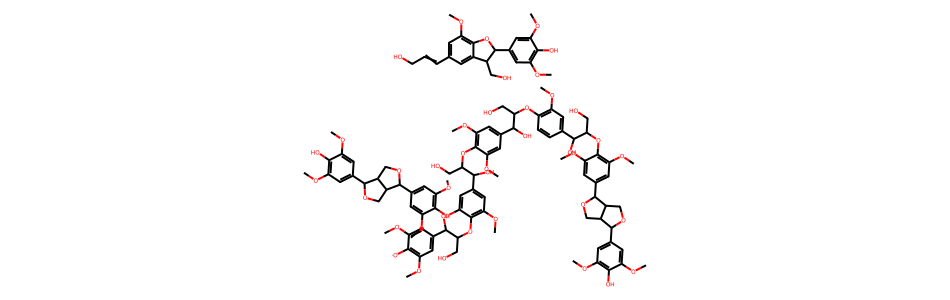

In [11]:
result = run_kmc(rxn_rates, initial_state,initial_events, n_max=max_num_monos, t_max=t_max, sg_ratio=sg_ratio)

# Convert the sparse matrix to a full array before printing
print("The adjacency matrix for the simulated lignin is:")
print(result[ADJ_MATRIX].toarray())

summary = analyze_adj_matrix(result[ADJ_MATRIX])
adj_analysis_to_stdout(summary)

nodes = result[MONO_LIST]
adj = result[ADJ_MATRIX]
block = generate_mol(adj, nodes)
mol = MolFromMolBlock(block)
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

In [12]:
sg_opts = [0.1, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 10]
num_repeats = 5
num_monos = 50

fun = par.delayed(run_kmc)
sg_result_list = []

for sg_ratio in sg_opts:
    # Set the percentage of S
    pct_s = sg_ratio / (1 + sg_ratio)
    
    # Make choices about what kinds of monomers there are and create them
    monomer_draw = np.random.rand(num_monos)
    initial_monomers = create_initial_monomers(pct_s, monomer_draw)
    
    # Initialize the monomers, events, and state
    initial_events = create_initial_events(initial_monomers, rxn_rates)
    initial_state = create_initial_state(initial_events, initial_monomers)

    results = par.Parallel(n_jobs=4)([fun(rxn_rates, initial_state, initial_events, n_max=num_monos, t_max=1)
                                      for _ in range(num_repeats)])
    
    sg_result_list.append(results)
    t = time.localtime()
    print('Completed sensitivity iteration for S to G ratio {:5.2f} on '
          '{}-{:02d}-{:02d} at {:02d}:{:02d}:{:02d}'.format(sg_ratio, t.tm_year, t.tm_mon, t.tm_mday,
                                                            t.tm_hour, t.tm_min, t.tm_sec))

Completed sensitivity iteration for S to G ratio  0.10 on 2023-05-24 at 13:44:55
Completed sensitivity iteration for S to G ratio  0.20 on 2023-05-24 at 13:46:53
Completed sensitivity iteration for S to G ratio  0.25 on 2023-05-24 at 13:48:51
Completed sensitivity iteration for S to G ratio  0.33 on 2023-05-24 at 13:50:43
Completed sensitivity iteration for S to G ratio  0.50 on 2023-05-24 at 13:52:28
Completed sensitivity iteration for S to G ratio  1.00 on 2023-05-24 at 13:53:55
Completed sensitivity iteration for S to G ratio  2.00 on 2023-05-24 at 13:54:44
Completed sensitivity iteration for S to G ratio  3.00 on 2023-05-24 at 13:55:35
Completed sensitivity iteration for S to G ratio  4.00 on 2023-05-24 at 13:56:27
Completed sensitivity iteration for S to G ratio  5.00 on 2023-05-24 at 13:57:04
Completed sensitivity iteration for S to G ratio 10.00 on 2023-05-24 at 13:57:37


In [14]:
num_sg_opts = len(sg_opts)
analysis = []

for i in range(num_sg_opts):
    sg_results = sg_result_list[i]
    cur_adjs = [sg_results[j][ADJ_MATRIX] for j in range(num_repeats)]
    analysis.append(par.Parallel(n_jobs=4)(par.delayed(analyze_adj_matrix)(cur_adjs[j])
                                           for j in range(num_repeats)))                                        
    t = time.localtime()
    print('Finished analysis for S:G of {:5.2f} on {}-{:02d}-{:02d} at '
          '{:02d}:{:02d}:{:02d}'.format(sg_opts[i], t.tm_year, t.tm_mon, t.tm_mday, 
                                        t.tm_hour, t.tm_min, t.tm_sec))
    

    


num_monos = [[sum([analysis[j][i][CHAIN_LEN][k] * k for k in analysis[j][i][CHAIN_LEN]]) 
              for i in range(num_repeats)] for j in range(num_sg_opts)]


betaO4_content = [[analysis[j][i][BONDS][BO4]/sum(analysis[j][i][BONDS].values())
                   for i in range(num_repeats)] for j in range(num_sg_opts)]
beta5_content = [[analysis[j][i][BONDS][B5]/sum(analysis[j][i][BONDS].values())
                  for i in range(num_repeats)] for j in range(num_sg_opts)]
betabeta_content = [[analysis[j][i][BONDS][BB]/sum(analysis[j][i][BONDS].values())
                     for i in range(num_repeats)] for j in range(num_sg_opts)]
beta1_content = [[analysis[j][i][BONDS][B1]/sum(analysis[j][i][BONDS].values())
                  for i in range(num_repeats)] for j in range(num_sg_opts)]
c5o4_content = [[analysis[j][i][BONDS][C5O4]/sum(analysis[j][i][BONDS].values())
                 for i in range(num_repeats)] for j in range(num_sg_opts)]
alphaO4_content = [[analysis[j][i][BONDS][AO4]/sum(analysis[j][i][BONDS].values())
                    for i in range(num_repeats)] for j in range(num_sg_opts)]
fivefive_content = [[analysis[j][i][BONDS][C5C5]/sum(analysis[j][i][BONDS].values())
                     for i in range(num_repeats)] for j in range(num_sg_opts)]

av_bo4_content = [np.mean(percent) for percent in betaO4_content]
std_bo4_content = [np.sqrt(np.var(percent)) for percent in betaO4_content]

av_b5_content = [np.mean(percent) for percent in beta5_content]
std_b5_content = [np.sqrt(np.var(percent)) for percent in beta5_content]

av_bb_content = [np.mean(percent) for percent in betabeta_content]
std_bb_content = [np.sqrt(np.var(percent)) for percent in betabeta_content]

av_b1_content = [np.mean(percent) for percent in beta1_content]
std_b1_content = [np.sqrt(np.var(percent)) for percent in beta1_content]

av_5o4_content = [np.mean(percent) for percent in c5o4_content]
std_5o4_content = [np.sqrt(np.var(percent)) for percent in c5o4_content]

av_ao4_content = [np.mean(percent) for percent in alphaO4_content]
std_ao4_content = [np.sqrt(np.var(percent)) for percent in alphaO4_content]

av_55_content = [np.mean(percent) for percent in fivefive_content]
std_55_content = [np.sqrt(np.var(percent)) for percent in fivefive_content]

Finished analysis for S:G of  0.10 on 2023-05-24 at 13:59:02
Finished analysis for S:G of  0.20 on 2023-05-24 at 13:59:03
Finished analysis for S:G of  0.25 on 2023-05-24 at 13:59:03
Finished analysis for S:G of  0.33 on 2023-05-24 at 13:59:03
Finished analysis for S:G of  0.50 on 2023-05-24 at 13:59:03
Finished analysis for S:G of  1.00 on 2023-05-24 at 13:59:03
Finished analysis for S:G of  2.00 on 2023-05-24 at 13:59:03
Finished analysis for S:G of  3.00 on 2023-05-24 at 13:59:03
Finished analysis for S:G of  4.00 on 2023-05-24 at 13:59:03
Finished analysis for S:G of  5.00 on 2023-05-24 at 13:59:03
Finished analysis for S:G of 10.00 on 2023-05-24 at 13:59:03


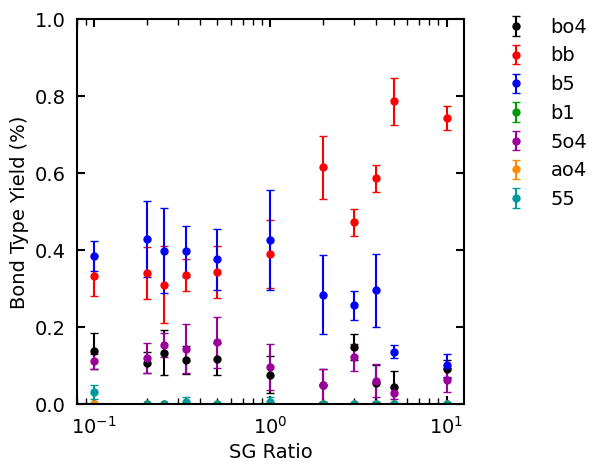

In [16]:
colors = [(0, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0.6, 0), (0.6, 0, 0.6), (1, 0.549, 0), 
          (0, 0.6, 0.6), (1, 0.8, 0), (0.6078, 0.2980, 0), (0.6, 0, 0), (0, 0, 0.6)]
plt.figure(figsize=(5,5))
plt.errorbar(sg_opts, av_bo4_content, yerr=std_bo4_content, linestyle='none', marker='.',
             markersize=10, markerfacecolor=colors[0], markeredgecolor=colors[0], label=BO4,
             capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts, av_bb_content, yerr=std_bb_content, linestyle='none', marker='.', markersize=10, 
             markerfacecolor=colors[1], markeredgecolor=colors[1], label=BB, capsize=3, ecolor=colors[1])
plt.errorbar(sg_opts, av_b5_content, yerr=std_b5_content, linestyle='none', marker='.', markersize=10,
             markerfacecolor=colors[2], markeredgecolor=colors[2], label=B5, capsize=3, ecolor=colors[2])
plt.errorbar(sg_opts, av_b1_content, yerr=std_b1_content, linestyle='none', marker='.', markersize=10, 
             markerfacecolor=colors[3], markeredgecolor=colors[3], label=B1, capsize=3, ecolor=colors[3])
plt.errorbar(sg_opts, av_5o4_content, yerr=std_5o4_content, linestyle='none', marker='.', markersize=10, 
             markerfacecolor=colors[4], markeredgecolor=colors[4], label=C5O4, capsize=3, ecolor=colors[4])
plt.errorbar(sg_opts, av_ao4_content, yerr=std_ao4_content, linestyle='none', marker='.', markersize=10, 
             markerfacecolor=colors[5], markeredgecolor=colors[5], label=AO4, capsize=3, ecolor=colors[5])
plt.errorbar(sg_opts, av_55_content, yerr=std_55_content, linestyle='none', marker='.', markersize=10, 
             markerfacecolor=colors[6], markeredgecolor=colors[6], label=C5C5, capsize=3, ecolor=colors[6])
plt.xscale('log')

[plt.gca().spines[i].set_linewidth(1.5) for i in ['top', 'right', 'bottom', 'left']]
plt.gca().tick_params(axis='both', which='major', labelsize=14, direction='in', pad=8, top=True, right=True, 
                      width=1.5, length=6)
plt.gca().tick_params(axis='both', which='minor', labelsize=14, direction='in', pad=8, top=True, right=True, 
                      width=1, length=4)
plt.ylabel('Bond Type Yield (%)', fontsize=14)
plt.xlabel('SG Ratio', fontsize=14)
plt.ylim([0.0, 1.0])
plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(1.2, 1.05), frameon=False)